#Import

In [1]:
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
path_dir='PATH DELLA DIRECTORY CONTENENTE I DATASET'

#Parametri

In [4]:
n_cluster = 3
top_slope = 9
range_cycle = 128

#Creazione dizionario dataframe

In [5]:
file_list = os.listdir(path_dir)
print(file_list)
#file 010 escluso perchè corrotto

['N-CMAPSS_DS05.h5', 'N-CMAPSS_DS06.h5', 'N-CMAPSS_DS04.h5', 'N-CMAPSS_DS07.h5', 'N-CMAPSS_DS08a-009.h5', 'N-CMAPSS_DS08c-008.h5', 'N-CMAPSS_DS01-005.h5', 'N-CMAPSS_DS02-006.h5', 'N-CMAPSS_DS03-012.h5']


In [6]:
#dizionario contente failure code di ogni file
code_failure = {
  'N-CMAPSS_DS01-005.h5': '1',
  'N-CMAPSS_DS03-012.h5': '2',
  'N-CMAPSS_DS05.h5': '3',
  'N-CMAPSS_DS06.h5': '4',
  'N-CMAPSS_DS07.h5': '5',
  'N-CMAPSS_DS08c-008.h5': '6'
}
file_list.remove('N-CMAPSS_DS02-006.h5')
#file 02 escluso in quanto non previsto dalla challenge e quindi senza informazioni
file_list.remove('N-CMAPSS_DS04.h5')
file_list.remove('N-CMAPSS_DS08a-009.h5')
#file 04,08 esclusi perchè altamente rumorosi

In [7]:
variable = ['W', 'X_s', 'A'] 
#Tolte X_v, T perchè contengono variabili artificiali
#Y aggiunta successivamente

In [8]:
#funzione che, a partire da ogni file, unisce le varibili di interesse in un unico dataset
def file_to_df(name_file, dset):
  df_list = []
  with h5py.File(path_dir+name_file, 'r') as hdf:
    for var in variable:
      column_name = np.array(hdf.get(var+'_var'))
      var_col = list(np.array(column_name, dtype='U20'))
      df_list.append(pd.DataFrame(np.array(h5py.File(path_dir+name_file)[var+'_'+dset]), columns=var_col))
    df_list.append(pd.DataFrame(np.array(h5py.File(path_dir+name_file)['Y_'+dset]), columns=['RUL']))
  return pd.concat(df_list, axis = 1)

#funzione che seleziona i valori centrali di ogni cycle per evitare di valutare le fasi transitorie del volo
def filter_df(df):
  df_filtered = pd.DataFrame()
  for i in range(1,101):
    cycle_df = df[df.cycle == i]
    start = (int(len(cycle_df)/2)) - (int(range_cycle/2))
    end = (int(len(cycle_df)/2)) + (int(range_cycle/2))
    cycle_df = cycle_df.iloc[start:end, :]
    df_filtered = pd.concat([df_filtered, cycle_df])
    df_filtered.reset_index(inplace=True, drop=True)
  return df_filtered

def file_to_filtered_df(name_file, dset):
  df= file_to_df(name_file, dset)
  df.columns = df.columns.astype(str)
  return filter_df(df)

In [9]:
#creazione dizionario con
#key = run to failure
#contenuto = dataframe filtrato
dict_files = dict()
for file in file_list:
  dict_files[code_failure[file]] = file_to_filtered_df(file, 'dev')

#Clustering

In [68]:
from sklearn import preprocessing, decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

In [69]:
#creazione del dataset su cui effettuare clustering
run_to_failure = list(code_failure.values())

# crea un dataframe con media valori del medesimo ciclo a partire da ogni run to failure
def processing_cluster(dict_set):
  df = pd.DataFrame()
  for elem in file_list:
    df_elem = dict_set[code_failure[elem]].groupby(['cycle']).mean()
    df_elem['code_failure'] = code_failure[elem] #Aggiunge una colonna con il codice della failure
    df = pd.concat([df, df_elem])
  return df


def clustering(df):
  # estrazione condizioni
  condition = df[['alt', 'Mach', 'TRA', 'T2']]
  rs = 1

  cond_scaler = preprocessing.StandardScaler().fit(condition)
  cond_pca = decomposition.PCA(n_components=0.95, random_state=rs).fit(condition)

  condition_transformed = cond_pca.transform(cond_scaler.transform(condition))

  #creazione variabile res contenente i risultati della fase di clustering
  kmeans = KMeans(n_clusters=n_cluster, random_state=rs).fit(condition_transformed)

  cluster_result = kmeans.predict(condition_transformed)
  res = df
  res['cluster'] = cluster_result
  return res


#creazione dizionario che divide i vari run to failure in cluster 
def create_res_dict(res, df_file):
 
  # gerarchia del dizionario clstr_dict
  # k: numero cluster
  # j: run to failure 
  clstr_dict = {k:{j:pd.DataFrame() for j in run_to_failure} for k in clusters} 

  res = res[['cycle', 'code_failure', 'cluster']]

  for elem in res.iterrows():
    df = df_file[elem[1].code_failure]
    df_cycle = df[df.cycle == elem[1].cycle]
    clstr_dict[elem[1].cluster][elem[1].code_failure] = pd.concat([clstr_dict[elem[1].cluster][elem[1].code_failure], df_cycle])
  
  return clstr_dict

In [70]:
df_cluster = processing_cluster(dict_files)
df_cluster.reset_index(inplace=True) 
#PCA
clusters = range(n_cluster)
result = clustering(df_cluster)
cluster_dict = create_res_dict(result, dict_files)

#Feature selection

In [71]:
import copy
from scipy.stats import spearmanr
import statistics
import math
import itertools
from scipy.stats import pearsonr

from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from scipy import fftpack
from pprint import pprint

In [72]:
#  RIMOZIONE VARIABILI
remove_var = ['alt','Mach','TRA','T2','unit','Fc','hs','RUL', 'cycle']

In [73]:
#funzione che applicata ad un segnale ritorna il numero di picchi in frequenza 
def num_peaks(cycle):
  f_s = 1  # frequenza di campionamento
  x_arr = np.array(cycle, dtype=object)
  X = fftpack.fft(x_arr)
  freqs = fftpack.fftfreq(len(cycle)) * f_s

  X_abs = np.abs(X)

  peaks, _ = find_peaks(X_abs, height = 0.18)
  return len(peaks)

In [74]:
# dizionario in cui vengono riportate le metriche associate ad ogni variabile quali:
  # - media
  # - varianza
  # - curtosi
  # - numero di picchi in frequenza

cluster_metrics = {k: {w: dict() for w in run_to_failure} for k in clusters}    

for i in clusters:
  for j in run_to_failure:
    for col in cluster_dict[i][j].columns:
      if col in remove_var: continue
      cluster_metrics[i][j]['mean'+'_'+col] = cluster_dict[i][j].groupby(['cycle'])[col].mean()
      cluster_metrics[i][j]['variance'+'_'+col] = cluster_dict[i][j].groupby(['cycle'])[col].var()
      cluster_metrics[i][j]['kurtosis'+'_'+col] = cluster_dict[i][j].groupby(['cycle'])[col].apply(pd.DataFrame.kurt)
      cluster_metrics[i][j]['num_peak'+'_'+col] = cluster_dict[i][j].groupby(['cycle'])[col].apply(num_peaks)

In [75]:
#funzione di normalizzaione
def normalization(set_to_norm):
  for i in clusters:
    for w in run_to_failure:
      for col in set_to_norm[i][w]:
        df = set_to_norm[i][w][col]
        set_to_norm[i][w][col]=(df-df.mean())/df.std()
      try:  
          if(len(set_to_norm[i][w][col]) == 1): set_to_norm[i][w] = {}
      except: 
          print(i,w)

normalization(cluster_metrics)

In [76]:
#definizione delle funzioni: monotonicity, prognosability e trendability per la valutazione delle feature  

#monotonicity
def monotonicity(cluster_id):
  M = len(run_to_failure)
  rtf = cluster_metrics[cluster_id]
  mono = {k: 0 for k in rtf['1']}
  for col in rtf['1']:
    acc_est = 0
    list_rtf = []
    for w in run_to_failure:
      list_rtf.append(rtf[w][col])
    for series in list_rtf:
      acc = 0
      index = []
      for i in series.index:
        index.append(i)
      for j in range(0, len(index)-1):
        acc += np.sign(series[index[j+1]] - series[index[j]])
      acc_est += abs(acc/(len(series)-1))
    mono[col] = acc_est/M
  return mono

#trendability
def trendability(cluster_id):
  rtf = cluster_metrics[cluster_id]
  trend = {k: 0 for k in rtf['1']}
  for col in rtf['1']:
    min_corr = 1
    for i,j in itertools.combinations(rtf.keys(),2): # per ogni coppia di run-to-failure
      a = rtf[i][col]
      b = rtf[j][col]
      min_len = min(len(a), len(b))
      if min_len < 2: continue
      corr, _ = pearsonr(a.head(min_len), b.head(min_len)) #correlazione tra xi e xj
      if abs(corr) < min_corr: min_corr = abs(corr)
    trend[col] = min_corr
  return trend

#prognosability
def prognosability(cluster_id):
  rtf = cluster_metrics[cluster_id]
  prog = {k: 0 for k in rtf['1']}
  for col in rtf['1']:
    list_rtf = []
    for w in run_to_failure:
      list_rtf.append(rtf[w][col])
    list_num = list(map(lambda x: x.values[-1], list_rtf))
    list_den = list(map(lambda x: abs(x.values[0] - x.values[-1]), list_rtf))
    num = np.std(list_num)
    den = np.mean(list_den)
    prog[col] = np.exp(-num/den)
  return prog

In [77]:
#dizionario contenente le feature
slope_dict = {k: dict() for k in clusters}

#pesi associati agli score
weight_trendability = 0.30
weight_monotonicity = 0.50
weight_prognosability = 0.20

for j in clusters:
  trendability_score = trendability(j)
  prognosability_score = prognosability(j)
  monotonicity_score = monotonicity(j)
  for col in cluster_metrics[j]['1']:
    slope_dict[j][col] = weight_trendability*trendability_score[col] + weight_prognosability*prognosability_score[col] + weight_monotonicity*monotonicity_score[col]

In [78]:
#  ordinamento in base alle feature
for j in clusters:
    slope_dict[j] = dict(sorted(slope_dict[j].items(), key=lambda item: abs(item[1]), reverse=True))
slope_dict_complete = copy.deepcopy(slope_dict)

In [79]:
# selezione delle feature migliori
for j in clusters:
  slope_dict[j] = dict(zip(list(slope_dict[j].keys())[:top_slope], list(slope_dict[j].values())[:top_slope]))
  print("Migliori feature cluster "+str(j))
  pprint(slope_dict[j], sort_dicts=False)
  print("")

Migliori feature cluster 0
{'variance_P2': 0.27166879233411545,
 'mean_T50': 0.20352347583953392,
 'num_peak_P2': 0.20004895466005326,
 'kurtosis_P2': 0.18698053076364624,
 'num_peak_T50': 0.1858526954916995,
 'mean_Ps30': 0.18134091040672762,
 'mean_P40': 0.1805205098279304,
 'mean_Wf': 0.18030460393777,
 'num_peak_P24': 0.17779959285693153}

Migliori feature cluster 1
{'mean_Nf': 0.18324121182931455,
 'mean_T48': 0.1751839345692493,
 'mean_T50': 0.16789417592535183,
 'mean_T24': 0.16319342109476231,
 'mean_T30': 0.16249658266954836,
 'mean_Nc': 0.16217577308838166,
 'num_peak_T24': 0.15727218285509528,
 'num_peak_T30': 0.15628593072331615,
 'mean_Ps30': 0.1550831001118589}

Migliori feature cluster 2
{'kurtosis_P24': 0.1934346074671712,
 'num_peak_T24': 0.17828528625338455,
 'mean_T50': 0.17510920791281454,
 'mean_T48': 0.1629076759572153,
 'kurtosis_P40': 0.1528066039476693,
 'num_peak_P40': 0.14910380489397762,
 'mean_P2': 0.14812137393135372,
 'num_peak_Ps30': 0.1458244346363793,


#Health indicator

In [80]:
from sklearn import linear_model
from scipy.io import savemat

In [81]:
# dizionario per la costruzione di un indice progressivo dei cicli divisi per:
  # - cluster
  # - run to failure
health_cluster_dict = {k: {w: pd.DataFrame() for w in run_to_failure} for k in clusters}

for i in clusters:
  for w in run_to_failure:
    length = len(cluster_dict[i][w]['cycle'].unique())
    health_cluster_dict[i][w].index = np.arange(1, length + 1)

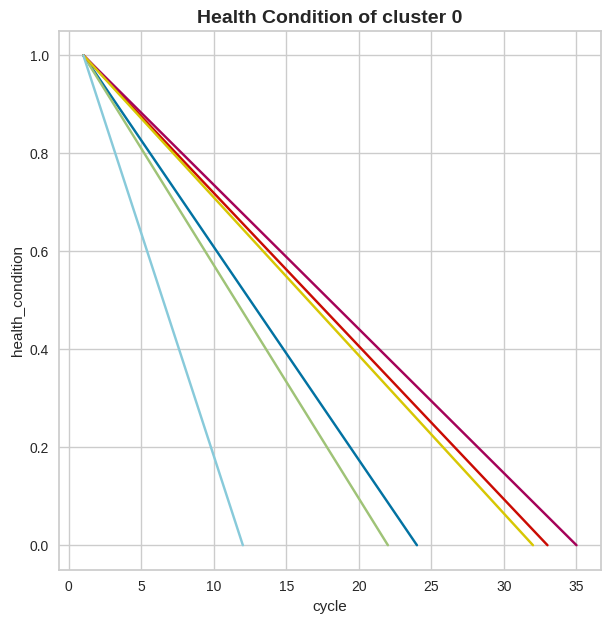

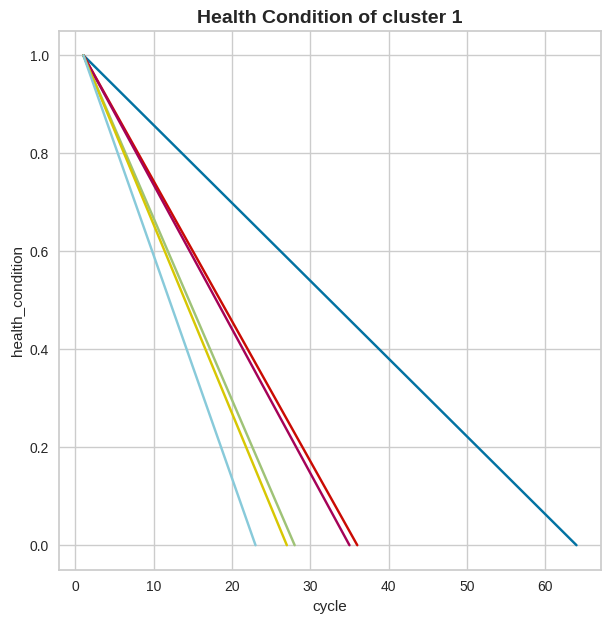

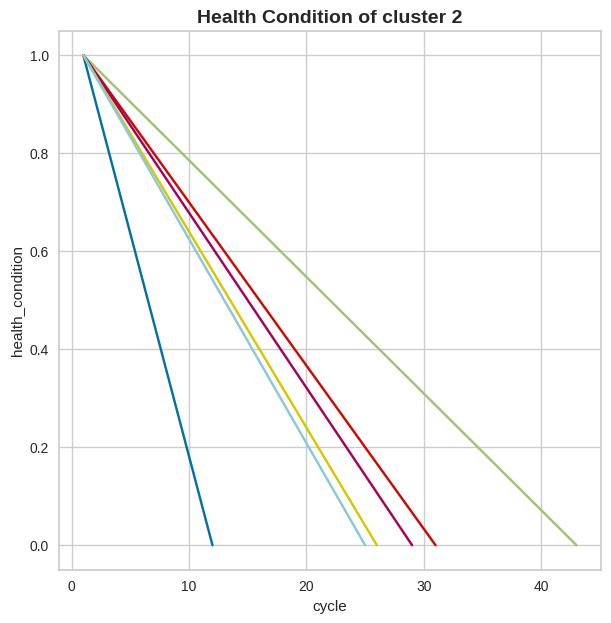

In [82]:
# costruzione dell'health condition lineare assegnando:
# ciclo 0 = 1
# ciclo N-esimo = 0 (N:= lunghezza del run to failure)

def health_condition(cluster_id, enable_plot, cluster_dict):
  if enable_plot:
    plt.figure(figsize=(7,7))
    plt.xlabel('cycle')
    plt.ylabel('health_condition')
    #plt.title(f'Health Condition of cluster {cluster_id}', fontsize=14, weight = 'bold')
  for w in run_to_failure:
    max_cycle = len(cluster_dict[cluster_id][w])
    cluster_dict[cluster_id][w]['cycle'] = cluster_dict[cluster_id][w].index
    cluster_dict[cluster_id][w]['rul'] = cluster_dict[cluster_id][w].apply(lambda x: max_cycle - x['cycle'], axis=1) 
    max_rul = cluster_dict[cluster_id][w]['rul'].max()

    #health_condition calcolata normalizzando la RUL rispetto al numero di cicli del run to failure 
    cluster_dict[cluster_id][w]['health_condition'] = cluster_dict[cluster_id][w].apply(lambda x: x['rul'] / max_rul, axis=1); 
    if enable_plot:
      plt.plot(cluster_dict[cluster_id][w]['cycle'], cluster_dict[cluster_id][w]['health_condition'])
  if enable_plot: 
    plt.savefig(path_dir+'/../plot/'+f'health_condition of cluster {cluster_id}.svg')   
    plt.show()

for i in clusters: health_condition(i, True, health_cluster_dict)

Cluster 0
rsquared rtf 1 = 0.689, numero cicli = 24
rsquared rtf 2 = 0.837, numero cicli = 22
rsquared rtf 3 = 0.617, numero cicli = 33
rsquared rtf 4 = 0.614, numero cicli = 35
rsquared rtf 5 = 0.42, numero cicli = 32
rsquared rtf 6 = 0.95, numero cicli = 12


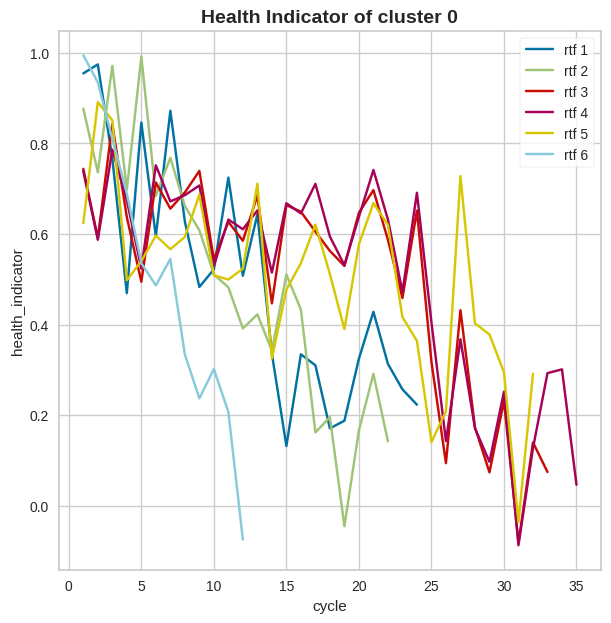

Cluster 1
rsquared rtf 1 = 0.589, numero cicli = 64
rsquared rtf 2 = 0.865, numero cicli = 28
rsquared rtf 3 = 0.858, numero cicli = 36
rsquared rtf 4 = 0.897, numero cicli = 35
rsquared rtf 5 = 0.947, numero cicli = 27
rsquared rtf 6 = 0.735, numero cicli = 23


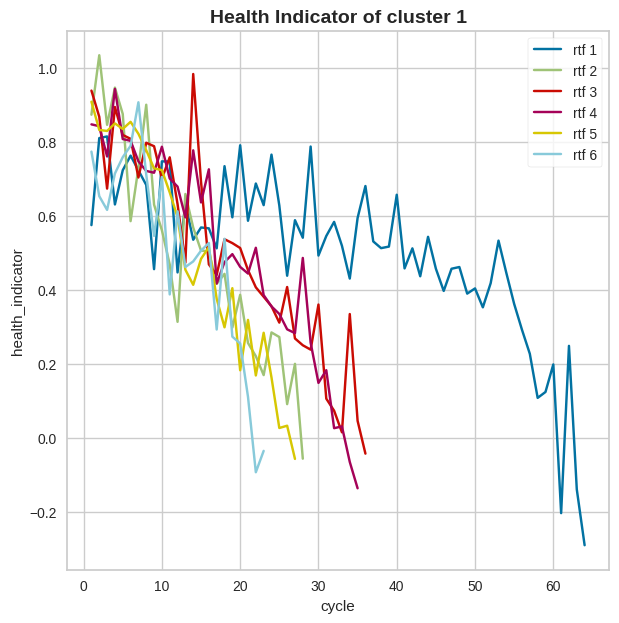

Cluster 2
rsquared rtf 1 = 0.941, numero cicli = 12
rsquared rtf 2 = 0.748, numero cicli = 43
rsquared rtf 3 = 0.89, numero cicli = 31
rsquared rtf 4 = 0.886, numero cicli = 29
rsquared rtf 5 = 0.811, numero cicli = 26
rsquared rtf 6 = 0.801, numero cicli = 25


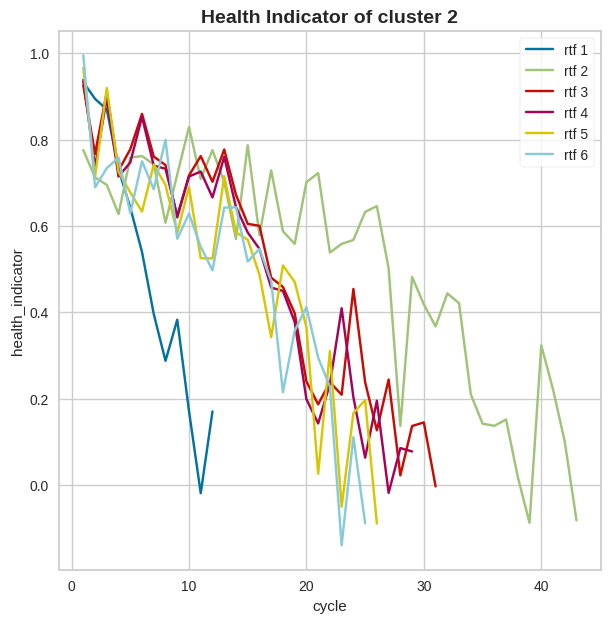

In [83]:
models_dict = {} #dizionario in cui andranno i modelli allenati
Y_pred_train = {i: {k: 0 for k in run_to_failure} for i in clusters} #dizionario in cui andranno registrati i risultati dei modelli: health indicator

for i in clusters:  
  plt.figure(figsize=(7,7))
  plt.xlabel("cycle")
  plt.ylabel("health_indicator")
  #plt.title('Health Indicator of cluster '+str(i), fontsize=14, weight = 'bold')
  print("Cluster "+ str(i))

  for w in run_to_failure:
    X_train = pd.DataFrame()
    for key in slope_dict[i].keys():
      X_train[key] = cluster_metrics[i][w][key]
    Y_train = health_cluster_dict[i][w]['health_condition']
    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)
    
    Y_pred_train[i][w] = model.predict(X_train)
    intercept = model.intercept_
    slope = model.coef_
    rsquared = model.score(X_train,Y_train)
    vals = cluster_dict[i][w].value_counts()
    print("rsquared rtf " + w + " = " + str(round(rsquared,3)) + ", numero cicli = "+ str(int(len(vals)/range_cycle)))
    plt.plot(health_cluster_dict[i][w]['cycle'], Y_pred_train[i][w], label="rtf "+w)
    plt.legend(frameon = True)

    models_dict[f'{i}_{w}'] = (model)

  plt.savefig(path_dir+'/../plot/'+f'health_indicator of cluster {i}.svg')
  plt.show()

#TEST


In [84]:
#finestratura del test set
dict_test = dict()
for file in file_list:
  dict_test[code_failure[file]] = file_to_filtered_df(file, 'test')

In [85]:
#funzione per il calcolo della similarità tra due serie
def similarity_model(a, b):
  min_len = min(len(a), len(b))
  return cosine_similarity([a[:min_len]], [b[:min_len]])[0][0]

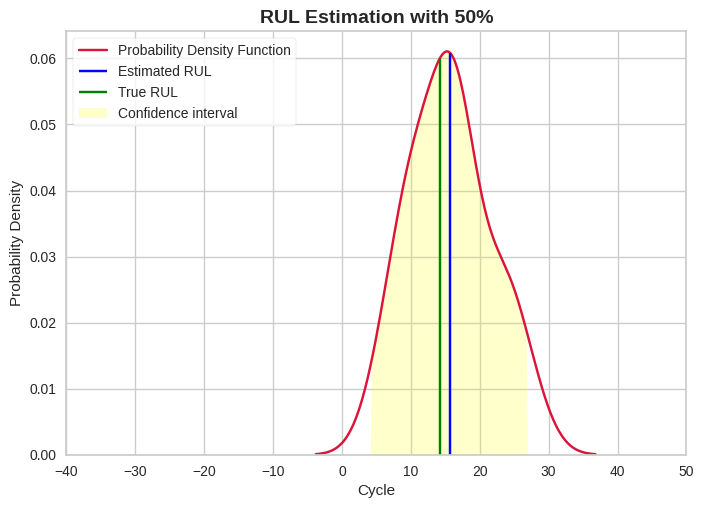

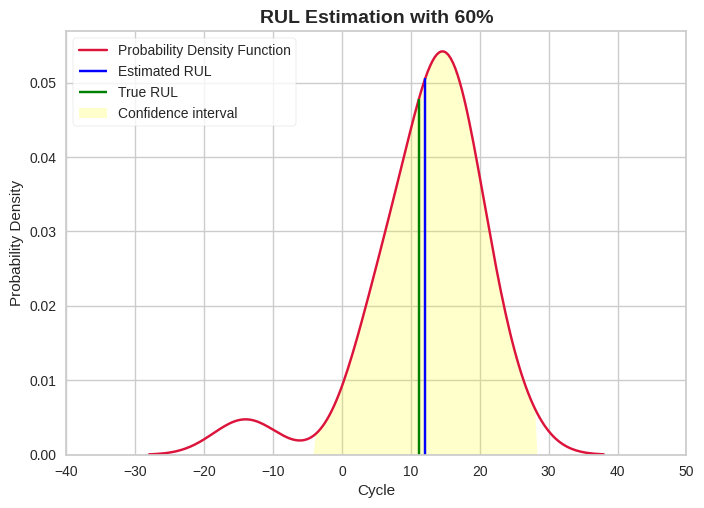

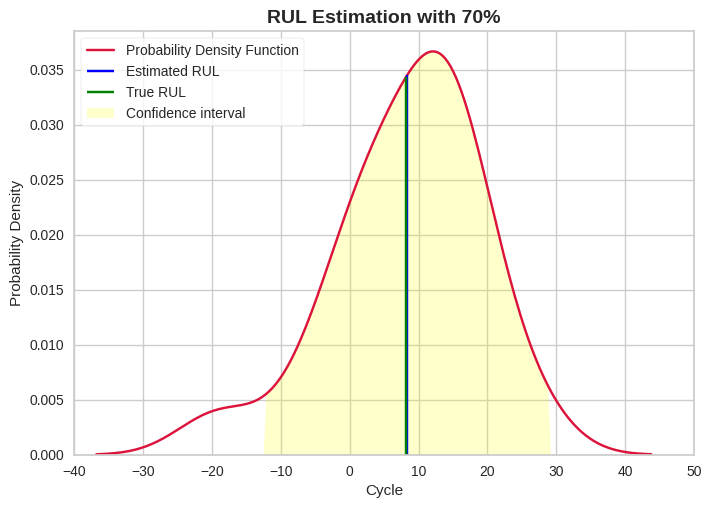

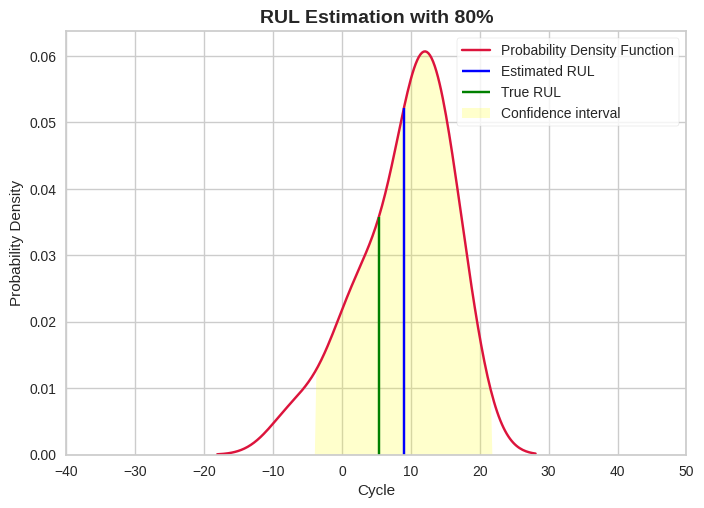

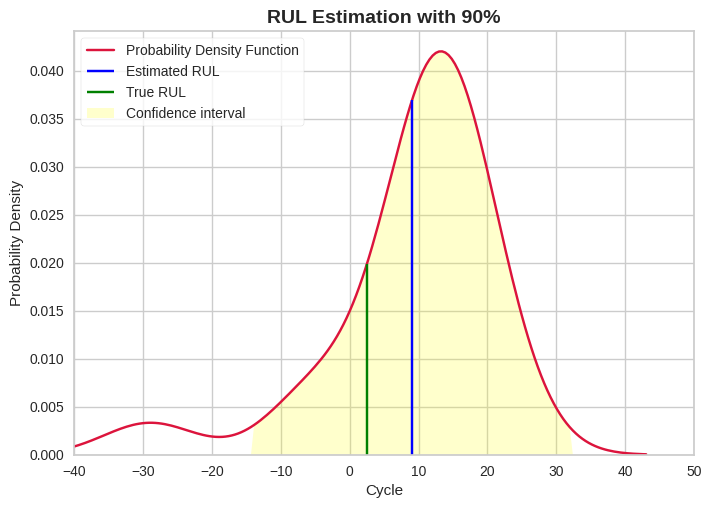

In [86]:
#iterazione da 50% a 90% del test set (passo di 10%)
for percentage in range(50,100,10):

  #processing e clustering come in fase di training
  df_test = processing_cluster(dict_test)
  df_test.reset_index(inplace=True) 
  result = clustering(df_test)
  test_dict_complete = create_res_dict(result, dict_test)
  test_dict = copy.deepcopy(test_dict_complete)

  #selezione dell' X% del test set 
  for i in clusters:
    for w in run_to_failure: # conosciamo il rtf perchè abbiamo file distinti, nel caso reale non li abbiamo, per questo applicheremo tutti i modelli
      end = int(len(test_dict[i][w])*(percentage/100))
      test_dict[i][w] = test_dict[i][w].head(end)

  #verifica il numero di cicli per ogni rtf di ogni cluster
  mismatch = []
  for i in clusters:
    for w in run_to_failure:
      res = result[result['cluster'] == i]
      res = res[res['code_failure'] == w]
      if (len(res) == 0): mismatch.append(f'{i}_{w}')
  
  #creazione delle metriche per il test
  test_metrics = {k: {w: dict() for w in run_to_failure} for k in clusters}    

  for i in clusters:
    for j in run_to_failure:
      for col in test_dict[i][j].columns:
        if col in remove_var: continue
        test_metrics[i][j]['mean'+'_'+col] = test_dict[i][j].groupby(['cycle'])[col].mean()
        test_metrics[i][j]['variance'+'_'+col] = test_dict[i][j].groupby(['cycle'])[col].var()
        test_metrics[i][j]['kurtosis'+'_'+col] = test_dict[i][j].groupby(['cycle'])[col].apply(pd.DataFrame.kurt)
        test_metrics[i][j]['num_peak'+'_'+col] = test_dict[i][j].groupby(['cycle'])[col].apply(num_peaks)

  
  normalization(test_metrics)   

  #dizionario in cui vengono riportati i risultati dei modelli nella fase di test
  Y_pred_test = {i: {k: [] for k in run_to_failure} for i in clusters}

  for i in clusters:
    for w in run_to_failure: # cicla per ogni dataset di test (file)

      if (len(test_metrics[i][w]) <= 0): continue #controllo numero cicli delle metriche

      X_test = pd.DataFrame()
      for key in slope_dict[i].keys(): # selezione delle feature 
        X_test[key] = test_metrics[i][w][key]
    
      for j in run_to_failure: # cicla per ogni modello (uno per rtf)
        try:
          Y_pred_test[i][w].append(models_dict[f'{i}_{j}'].predict(X_test)) #aggiunge alla lista un array con i parametri di regressione
        except:
          print(i,w)

  #creazione dataframe con indice il ciclo ordinato da 1 a n 
  health_test_dict = {k: {w: pd.DataFrame() for w in run_to_failure} for k in clusters}
  
  #creazione dell'health condition come in fase di training
  for i in clusters:
    for w in run_to_failure:
      if (not test_metrics[i][w].keys()): continue
      length = len(test_dict_complete[i][w]['cycle'].unique())
      health_test_dict[i][w].index = np.arange(1, length + 1)


  for i in clusters: health_condition(i, False, health_test_dict)

  #dizionario contenente i risultati del processo
  rul = {'REAL_RUL':[], 'PREDICTED_RUL':[], 'RTF':[], 'BEST_MODEL':[]}

  for i in clusters:
    for w in run_to_failure: # per ogni serie di test
      
      #controllo numero di cicli
      if (len(test_metrics[i][w]) <= 1): 
        print(i,w)
        continue # se la serie è vuota (rtf non clusterizzato in uno dei cluster)
      
      j = 0
      similarity = dict() #dizionario in cui vengono registrati i valori di similarità
      for serie in Y_pred_test[i][w]: # cicla tutte le serie predette
        j += 1
        similarity[f'{w}_{j}'] = similarity_model(serie, Y_pred_train[i][str(j)]) # similarità tra la serie di test e la predizione del corrispettivo modello di training

      sorted_similarity = dict(sorted(similarity.items(), key=lambda item: item[1], reverse=True)) #ordinamento delle similarità
      top2 = list(sorted_similarity.items())[:2] #selezione dei 2 modelli migliori
      
      #estrazione chiave e rtf per ognuno dei due modelli
      model_a = top2[0][0].split('_')[1]
      model_a_key = f'{i}_{model_a}' 

      model_b = top2[1][0].split('_')[1]
      model_b_key = f'{i}_{model_b}'


      #per ognuno dei due modelli si esegue una predizione sulla base delle feature migliori 
      #e si estraggono gli ultimi 3 valori di health indicator predetti 
      Xa_test = pd.DataFrame()
      for key in slope_dict[i].keys(): 
        Xa_test[key] = test_metrics[i][w][key]
      health_cond_a = models_dict[f'{i}_{model_a}'].predict(Xa_test)
      health_cond_a = np.mean(health_cond_a[-3:])

      Xb_test = pd.DataFrame()
      for key in slope_dict[i].keys(): 
        Xb_test[key] = test_metrics[i][w][key]
      health_cond_b = models_dict[f'{i}_{model_b}'].predict(Xb_test)
      health_cond_b = np.mean(health_cond_b[-3:])

      #RUL STIMATA := health condition * numero massimo di cicli del test set in esame (denormalizzazione della RUL)
      rul_a = health_cond_a * len(health_cluster_dict[i][str(model_a)]['cycle'])
      rul_b = health_cond_b * len(health_cluster_dict[i][str(model_b)]['cycle'])

      #media pesata della rul stimata 
      mean_rul = int((rul_a*70 + rul_b*30)/100)

      #RUL REALE := numero di cicli del test set in esame * percentuale di test set
      real_rul = int(len(health_test_dict[i][w])*(100-percentage)/100)

      rul['REAL_RUL'].append(real_rul)
      rul['PREDICTED_RUL'].append(mean_rul)
      rul['RTF'].append(f'{i}_{w}')
      rul['BEST_MODEL'].append(f'{i}_{model_a}')

  rul_df = pd.DataFrame(rul)

  #rmse = mean_squared_error(rul_df['REAL_RUL'], rul_df['PREDICTED_RUL'], squared=False)

  x =  np.array(rul['PREDICTED_RUL'])
  x_real = np.array(rul['REAL_RUL'])
  

  ax = sns.kdeplot(x, shade=False, color='crimson', label="Probability Density Function") #pdf 
  kdeline = ax.lines[0]

  mean = x.mean() #valor medio della RUL stimata
  mean_real = x_real.mean() #valor medio della RUL reale

  xs = kdeline.get_xdata()
  ys = kdeline.get_ydata()

  # estrapolazioni dei valori per intervallo di confidenza (2*deviazione standard)
  sdev = x.std()
  left = mean - 2*sdev
  right = mean + 2*sdev

  height = np.interp(mean, xs, ys)
  height_real = np.interp(mean_real, xs, ys)

  ax.vlines(mean, 0, height, color='blue', ls='solid', label="Estimated RUL")
  ax.vlines(mean_real, 0, height_real, color='green', ls='solid', label="True RUL")

  ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='yellow', alpha=0.2, label="Confidence interval" )
  plt.xlim([-40, 50])
  plt.legend(frameon = True)
  #plt.title('RUL Estimation with '+str(percentage)+'%', fontsize=14, weight = 'bold')
  plt.xlabel('Cycle')
  plt.ylabel('Probability Density')
  plt.savefig(path_dir+'/../plot/'+f'RUL Estimation with '+str(percentage)+'.svg')
  plt.show()
